In [1]:
import cosima_cookbook as cc
import matplotlib.pyplot as plt
import numpy as np
import netCDF4 as nc
import xarray as xr
import cf_xarray
import cartopy.crs as ccrs
import cmocean as cm
import logging
from dask.distributed import Client
import matplotlib.path as mpath
import scipy as sp
import scipy.interpolate
import scipy.ndimage
import scipy.io
import scipy.stats
import pandas as pd
from pandas import DataFrame
import cartopy.feature as cft
from metpy.interpolate import cross_section
from pathlib import Path
import xgcm
from pyproj import Proj, transform
import gsw
from xhistogram.xarray import histogram

In [2]:
client = Client(n_workers=8)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 8
Total threads: 32,Total memory: 251.18 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:42949,Workers: 8
Dashboard: /proxy/8787/status,Total threads: 32
Started: Just now,Total memory: 251.18 GiB
Comm: tcp://127.0.0.1:33383,Total threads: 4
Dashboard: /proxy/37263/status,Memory: 31.40 GiB
Nanny: tcp://127.0.0.1:39927,


In [3]:
session = cc.database.create_session('/g/data/ik11/databases/cosima_master.db')

In [4]:
experiment = '01deg_jra55v140_iaf_cycle2'
start_t = '2004-01-01 00:00:00' # start date, 
end_t = '2006-01-01 00:00:00' # end date

In [5]:
# load conservative temperature and practical salinity
t = cc.querying.getvar(experiment, 'temp', session, frequency = '1 monthly',
                       start_time=start_t, end_time=end_t)-273.15
s = cc.querying.getvar(experiment, 'salt', session, frequency = '1 monthly',
                       start_time=start_t, end_time=end_t)

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/xarray/core/dataset.py:271: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/xarray/core/dataset.py:271: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/xarray/core/dataset.py:271: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3

Get the potential density by using gsw

In [21]:
def pot_rho(temp,salt):
    # practical salinity to absolute salinity
    salt_ab = gsw.conversions.SA_from_SP(salt,salt.st_ocean,salt.xt_ocean,salt.yt_ocean)
    
    # transfer to potential density you want
    rho = gsw.density.rho(salt_ab, temp,250)

    return rho

In [22]:
# get the density
rho = pot_rho(t,s)

Get two variables you want to compare

In [23]:
# two time periods
start_t_1 = '2005-01-01'
end_t_1 = '2005-12-31'

start_t_2 = '2004-01-01'
end_t_2 = '2004-12-31'

time_1 = slice(start_t_1,end_t_1)
time_2 = slice(start_t_2,end_t_2)

In [24]:
# study area
latrange = slice(-73.5,-50)
lonrange = slice(-110,-109)

In [25]:
def var(var,time_1,time_2,latrange,lonrange):
    var_1 = var.sel(time = time_1).sel(xt_ocean = lonrange).sel(yt_ocean = latrange).mean(('time','xt_ocean'))
    var_2 = var.sel(time = time_2).sel(xt_ocean = lonrange).sel(yt_ocean = latrange).mean(('time','xt_ocean'))

    return [var_1,var_2]

In [26]:
# Here I want to compare temperatures

temp_1, temp_2 = var(t, time_1, time_2, latrange, lonrange)
rho_1, rho_2 = var(rho, time_1, time_2, latrange, lonrange)

In [27]:
temp_1.load()
temp_2.load()
rho_1.load()
rho_2.load()

<xarray.DataArray 'salt' (st_ocean: 75, yt_ocean: 485)> Size: 291kB
array([[1028.35132751, 1028.35662492, 1028.35856586, ..., 1027.84411187,
        1027.84159759, 1027.83900778],
       [1028.35195099, 1028.35733289, 1028.35932186, ..., 1027.84408689,
        1027.84158735, 1027.83901123],
       [1028.35322612, 1028.358751  , 1028.36090452, ..., 1027.84424883,
        1027.84175316, 1027.83918009],
       ...,
       [          nan,           nan,           nan, ...,           nan,
                  nan,           nan],
       [          nan,           nan,           nan, ...,           nan,
                  nan,           nan],
       [          nan,           nan,           nan, ...,           nan,
                  nan,           nan]])
Coordinates:
  * yt_ocean  (yt_ocean) float64 4kB -73.46 -73.42 -73.38 ... -50.09 -50.03
  * st_ocean  (st_ocean) float64 600B 0.5413 1.681 2.94 ... 5.511e+03 5.709e+03

Then we are going to calculate the temperature change decomposition

# Method 2: xgcm.Grid to do isopycnal bins

In [28]:
# non-linear isopycnal bins for sigma_1
# Create the first array
bin1 = np.arange(20, 25, 0.1)
# Create the second array
bin2 = np.arange(25, 35, 0.02)
# Concatenate the two arrays
isopycnal_bins = np.concatenate((bin1, bin2))

In [35]:
isopycnal_bins = np.arange(1026.5,1029.1,.02)

To transfer isopycnal temperature changes from density to depth coordinate, we will have a depth grid

In [36]:
# the depth and lat coordinate in the model
st_ocean = temp_1.st_ocean.values
yt_ocean = temp_1.yt_ocean.values
# get the 2d_grid of depth
depth = np.zeros((len(st_ocean),len(yt_ocean)))
for j in range(len(yt_ocean)):
    depth[:,j] = st_ocean

depth = xr.DataArray(depth, dims = ['st_ocean','yt_ocean'], coords = [temp_1.st_ocean, temp_1.yt_ocean])

In [37]:
from xgcm import Grid

In [38]:
def isopycnal_temp_change(var_1, var_2, rho_1,rho_2):
    # get the grid dataset you want to transfer
    ds_1 = xr.Dataset({'var_1': var_1, 'rho_1': rho_1})
    ds_2 = xr.Dataset({'var_2': var_2, 'rho_2': rho_2})
    grid_1 = Grid(ds_1, coords={'Z': {'center':'st_ocean'}}, periodic=False)
    grid_2 = Grid(ds_2, coords={'Z': {'center':'st_ocean'}}, periodic=False)
    # transfer vars from depth coord to isopycnal bins
    var_1_rho = grid_1.transform(ds_1.var_1, 'Z', isopycnal_bins, target_data=ds_1.rho_1,method='linear')
    var_1_rho = var_1_rho.rename({'rho_1': 'pot_rho_1'})
    var_2_rho = grid_2.transform(ds_2.var_2, 'Z', isopycnal_bins, target_data=ds_2.rho_2,method='linear')
    var_2_rho = var_2_rho.rename({'rho_2': 'pot_rho_1'})
    # create depth(t,pot_rho,y,x)
    ds_depth = xr.Dataset({'pot_rho_1': (rho_1+rho_2)/2, 'depth': depth})
    grid = Grid(ds_depth, coords={'Z': {'center':'st_ocean'}}, periodic=False)
    depth_rho = grid.transform(ds_depth.depth, 'Z', isopycnal_bins, target_data=ds_depth.pot_rho_1,method='linear')
    # Compute the anomaly in density coords, then transfer ano to depth coords
    var_ano_rho = var_2_rho-var_1_rho
    ds_ano = xr.Dataset({'depth': depth_rho, 'var_ano': var_ano_rho})
    grid = Grid(ds_ano, coords={'Pot_rho_1': {'center':'pot_rho_1'}}, periodic=False)
    depth_bin = np.concatenate((np.arange(0,200.,0.02), np.arange(200.,6000.,10.)))
    var_ano_depth = grid.transform(ds_ano.var_ano, 'Pot_rho_1', depth_bin, target_data=ds_ano.depth,method='linear')

    return [var_1_rho,var_2_rho,var_ano_rho,var_ano_depth,depth_rho] 

In [39]:
# get the values
T_1_rho,T_2_rho,T_ano_rho,T_ano_depth,depth_rho = isopycnal_temp_change(temp_1, temp_2, rho_1,rho_2)

In [40]:
T_ano_depth = T_ano_depth.transpose('depth','yt_ocean')
T_ano_depth = T_ano_depth.interp(depth = st_ocean, method = 'linear')
T_ano_depth = T_ano_depth.rename({'depth':'st_ocean'})

Text(0.5, 1.0, 'Isopycnal heaving')

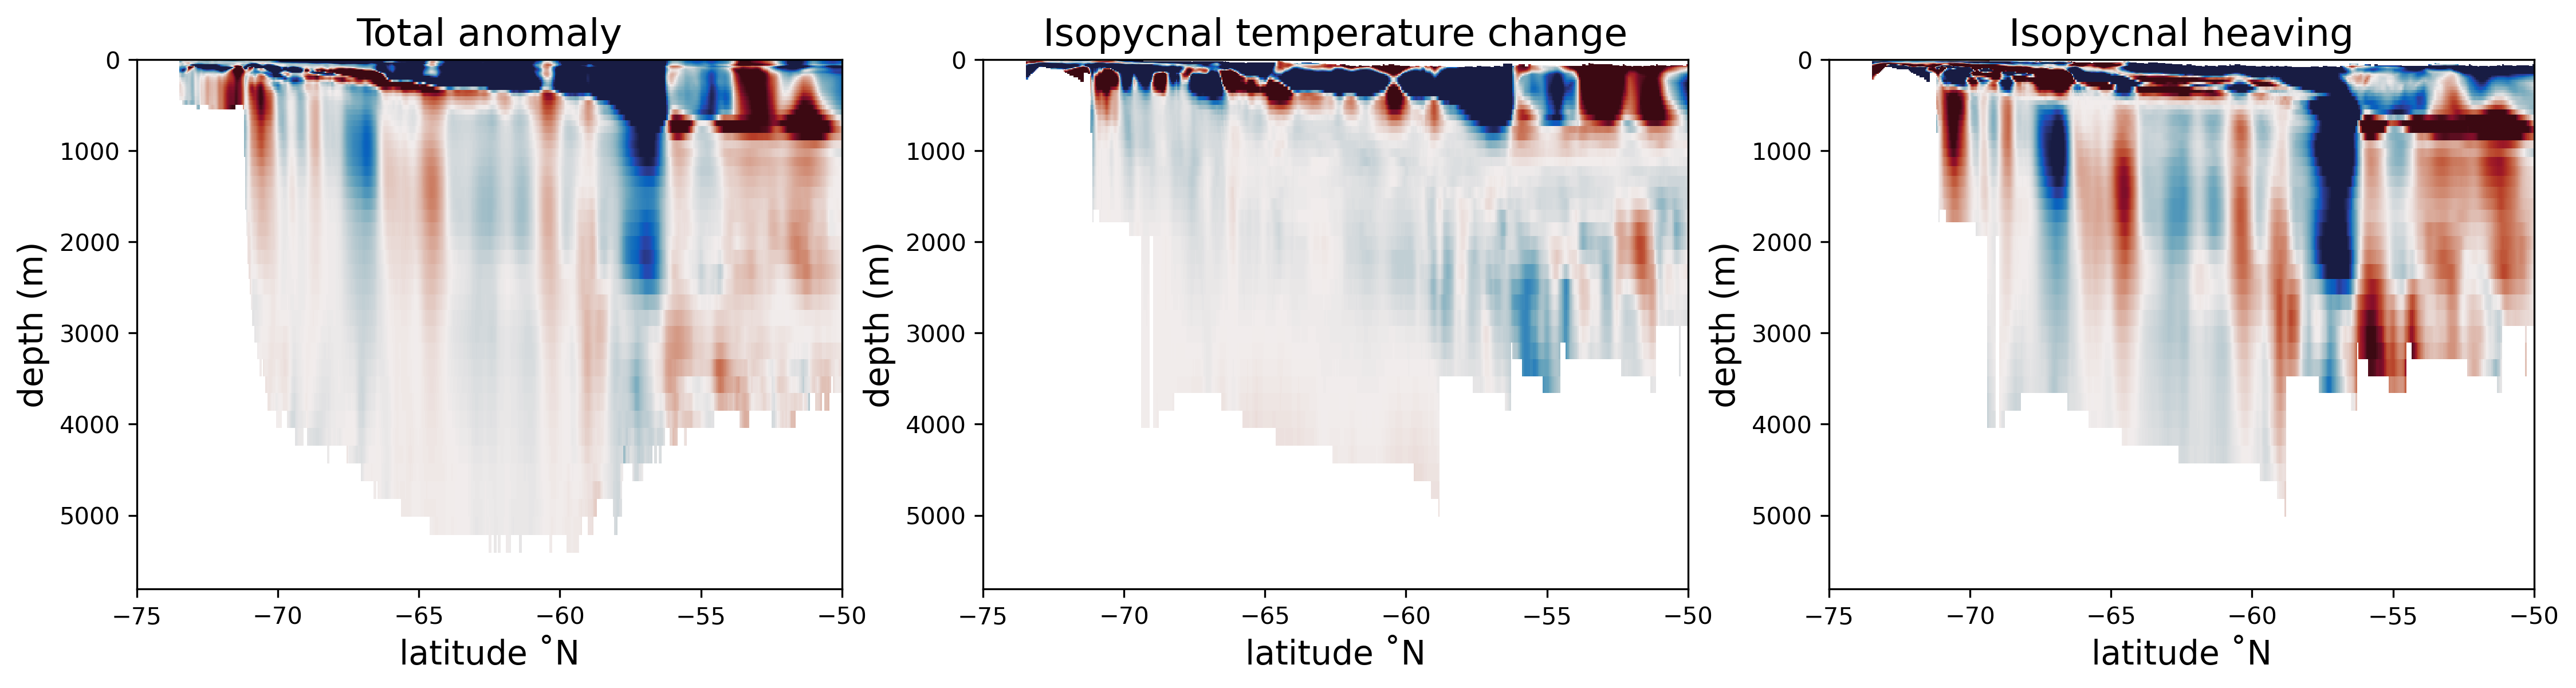

In [41]:
fig = plt.figure(figsize=(18,4),dpi = 300)

ax = plt.subplot(1,3,1)

p2 = (temp_2-temp_1).plot(vmin=-0.2,vmax=0.2, cmap = cm.cm.balance,add_colorbar = False)
plt.gca().invert_yaxis()
plt.xlim(-75,-50)
plt.xlabel('latitude ˚N',fontsize = 14)
plt.ylabel('depth (m)',fontsize = 14)
ax.set_title('Total anomaly',fontsize = 16)

ax = plt.subplot(1,3,2)
p2 = (T_ano_depth).plot(vmin=-0.1,vmax=0.1, cmap = cm.cm.balance,add_colorbar = False)
plt.gca().invert_yaxis()
plt.xlim(-75,-50)
plt.xlabel('latitude ˚N',fontsize = 14)
plt.ylabel('depth (m)',fontsize = 14)
ax.set_title('Isopycnal temperature change',fontsize = 16)

ax = plt.subplot(1,3,3)
p2 = (temp_2-temp_1-T_ano_depth).plot(vmin=-0.1,vmax=0.1, cmap = cm.cm.balance,add_colorbar = False)
plt.gca().invert_yaxis()
plt.xlim(-75,-50)
plt.xlabel('latitude ˚N',fontsize = 14)
plt.ylabel('depth (m)',fontsize = 14)
ax.set_title('Isopycnal heaving',fontsize = 16)